## Final notebook 3: BERT 

In [ ]:
pip install transformers

**BERT** Bidirection Encoder Representtion Tronsformers
-> Bidirectional - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
Research paper for bert 
https://arxiv.org/pdf/1810.04805.pdf

->Transformers - The **Attention Is All You Need** paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim or let's just say king refers to a man and queen to a woman).
Attention is all you need:-
https://arxiv.org/pdf/1706.03762.pdf

-> (Pre-trained) contextualized word embeddings - The **ELMO paper** introduced a way to encode words based on their meaning/context.
here's the link for the paper:-
https://arxiv.org/pdf/1802.05365v2.pdf

Importing all the libraries

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Adjusting colour palette for graph

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading dataset

In [ ]:
df = pd.read_csv("data_clustered_tweets.csv")
df.head()

,id,Tweet,Cluster
0,0,please check what happens this woking since lo...,0
1,4,network fluctuations speed pathetic need alter...,4
2,0,this been going since this absolutely unprofes...,0
3,0,have done recharge haven perday with unlimited...,0
4,6,when still received call from customer care ve...,6


In [ ]:
df.shape

(19501, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19501 entries, 0 to 19500
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       19501 non-null  int64 
 1   Tweet    19501 non-null  object
 2   Cluster  19501 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 457.2+ KB


Text(0.5, 0, 'cluster score')

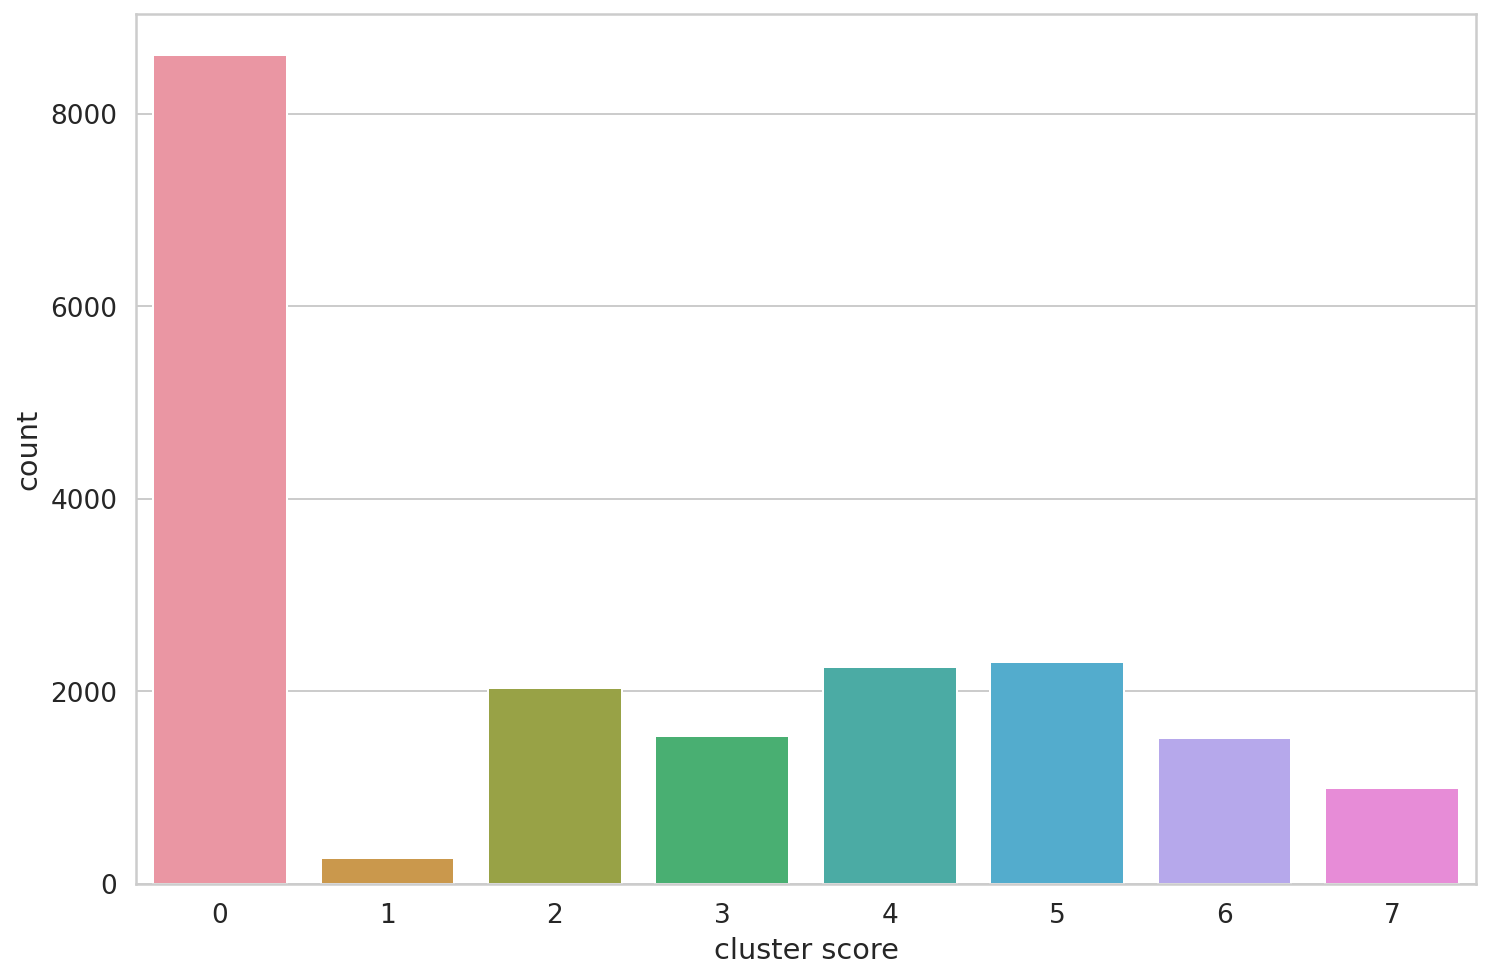

In [ ]:
sns.countplot(df.Cluster)
plt.xlabel('cluster score')

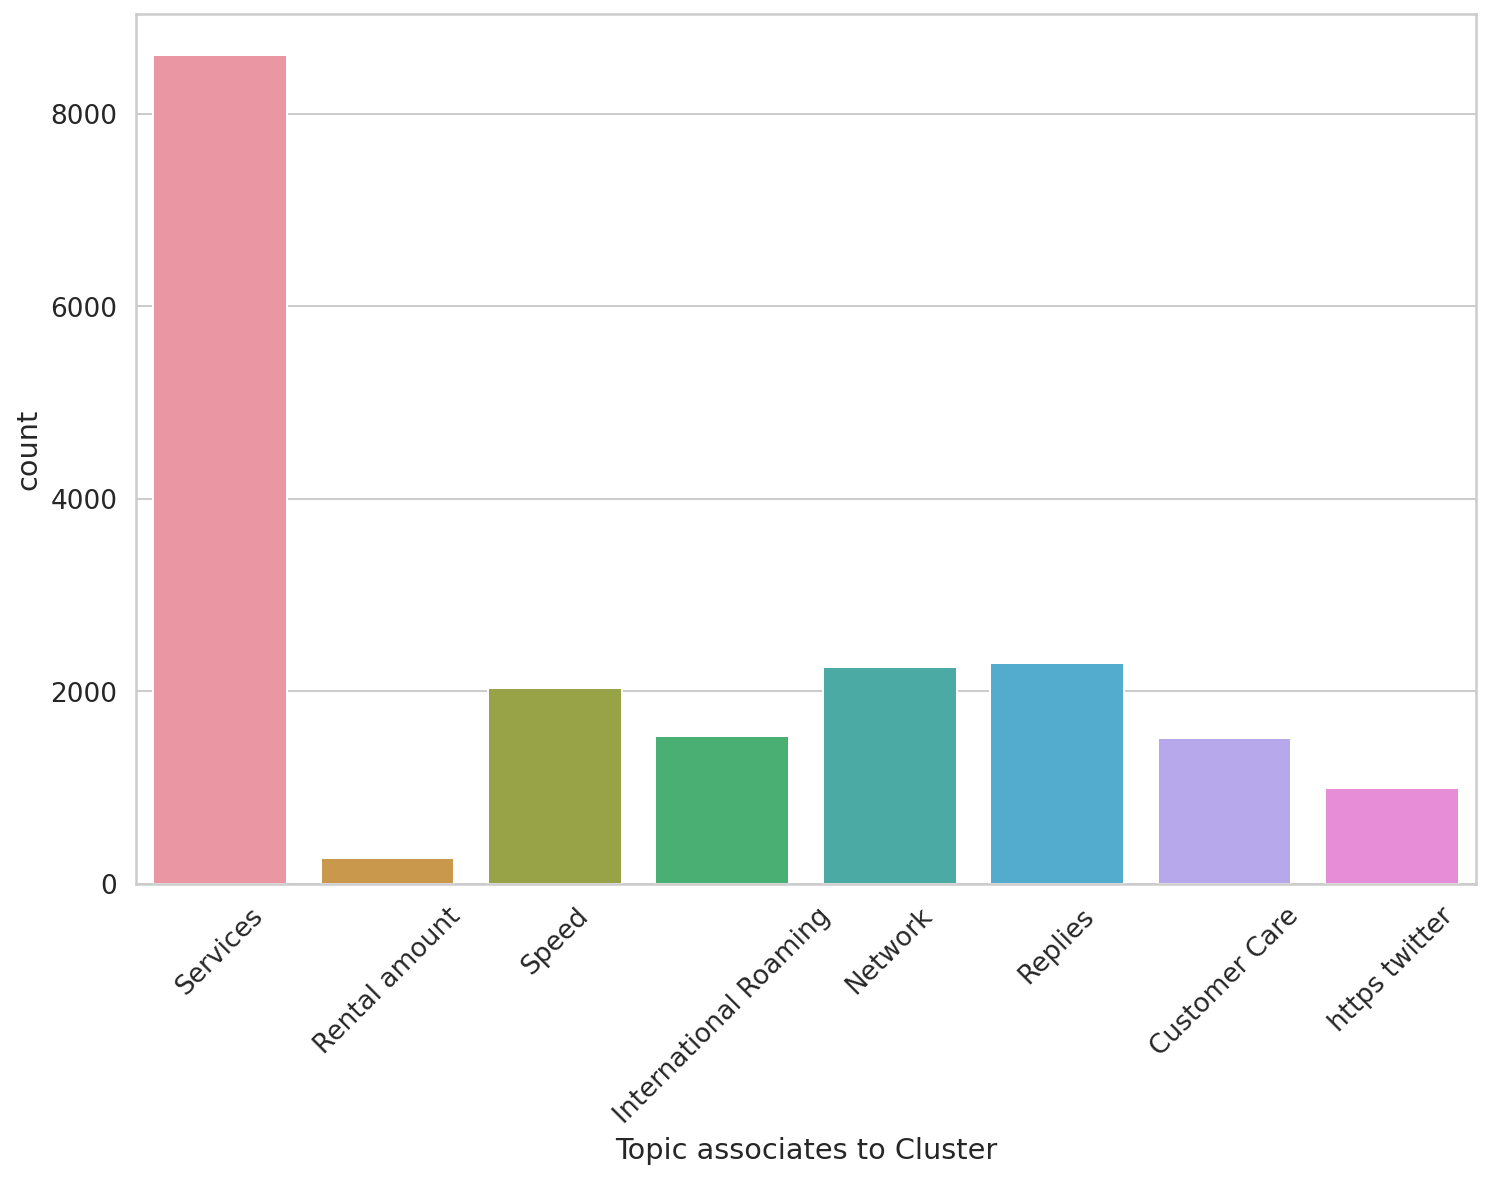

In [ ]:
def C_N(rating):
    num = row['Cluster']
    if(num==0):
        return "Services"
    elif(num==1):
        return "Rental amount"
    elif(num==2):
        return "Speed"
    elif(num==3):
        return "International Roaming"
    elif(num==4):
        return "Network"
    elif(num==5):
        return "Replies"
    elif(num==6):
        return "Customer Care"
    elif(num==7):
        return "https twitter"
#df['sentiment'] = df.Cluster.apply(to_sentiment)
class_names = ['Services', 'Rental amount', 'Speed','International Roaming','Network',
               'Replies','Customer Care','https twitter']
ax = sns.countplot(df.Cluster)
plt.xlabel('Topic associates to Cluster')
plt.xticks(rotation=45)
ax.set_xticklabels(class_names);

Data Preprocessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Lets load a pre-trained Bert Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this sample text to undestand process of tokenization.

In [ ]:
sample_txt='When was i last outside? I am stuck at home for2 weeks.'

In [ ]:
tokens= tokenizer.tokenize(sample_txt)
token_ids= tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f' Tokens: {tokens}')
print(f' Token_ids: {token_ids}')

 Sentence: When was i last outside? I am stuck at home for2 weeks.
 Tokens: ['When', 'was', 'i', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '##2', 'weeks', '.']
 Token_ids: [1332, 1108, 178, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 1477, 2277, 119]


Below are Special tokens

SEP -> marker of ending of sentence

CLS -> We must add this token to the start of each sentence so BERT knows we are preforming Classification

PAD -> token for padding 

what is paddinng?

-> not all tweet length are same so in order to have the inputs with the same size, this is where the padding is necessary

-**additional zeros** for short sentences and

-***truncating*** the sentences which exceed the max number of words which is declared by maxlen.

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In typical sentence classification, sentences are padded with 0's to get sentences of equal length and allow subsequent classification.

In [ ]:
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

Tokenizing unknown words.

fow words which are unknow to BERT's dictionary, although bert has a dictionary of 30,000 words!

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=16, # should be preferably of base2 eg, 8,16,32,64,128 etc
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

16


tensor([ 101, 1332, 1108,  178, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111, 1477, 2277,  102])

It's a mask to be used if the input sequence length is smaller than the max input sequence length in the current batch. 

It's the mask that we typically use for attention when a batch has varying length sentences

(here in our dataset we require attention masking as lengths of the tweets difer from user to user)

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

16


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Inverse of tokenization.

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '##2',
 'weeks',
 '[SEP]']

In [ ]:
token_lens=[]
for txt in df.Tweet:
  tokens= tokenizer.encode(txt, max_length=70)
  token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

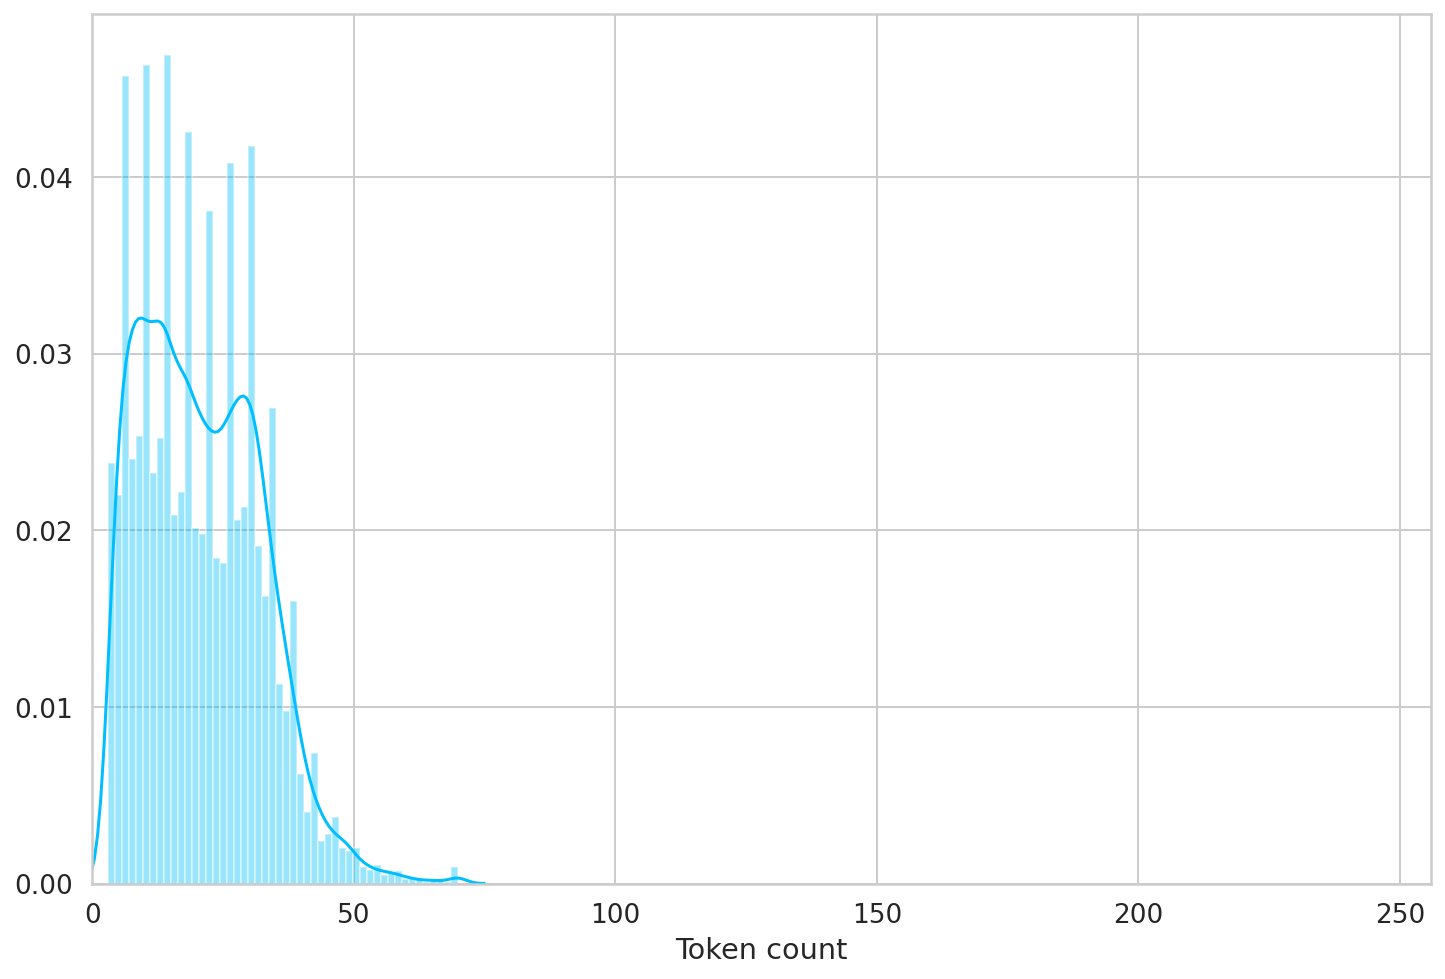

In [ ]:
sns.distplot(token_lens)
plt.xlim([0,256])
plt.xlabel('Token count')

In [ ]:
MAX_LEN= 60

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, Tweet, targets, tokenizer, max_len):
    self.Tweet = Tweet
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.Tweet)
  def __getitem__(self, item):
    Tweet = str(self.Tweet[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      Tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'Tweet_text': Tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test= train_test_split(df,test_size=0.1,random_state=RANDOM_SEED)
df_val, df_test= train_test_split(df,test_size=0.5,random_state=RANDOM_SEED)
df_train.shape, df_val.shape,df_test.shape

((17550, 3), (9750, 3), (9751, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    Tweet=df.Tweet.to_numpy(),
    targets=df.Cluster.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 256
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

data.keys()

dict_keys(['Tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([256, 60])
torch.Size([256, 60])
torch.Size([256])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 16, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

For using preferred Dropout probablity size

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([256, 60])
torch.Size([256, 60])


In [ ]:
#F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


RuntimeError: ignored

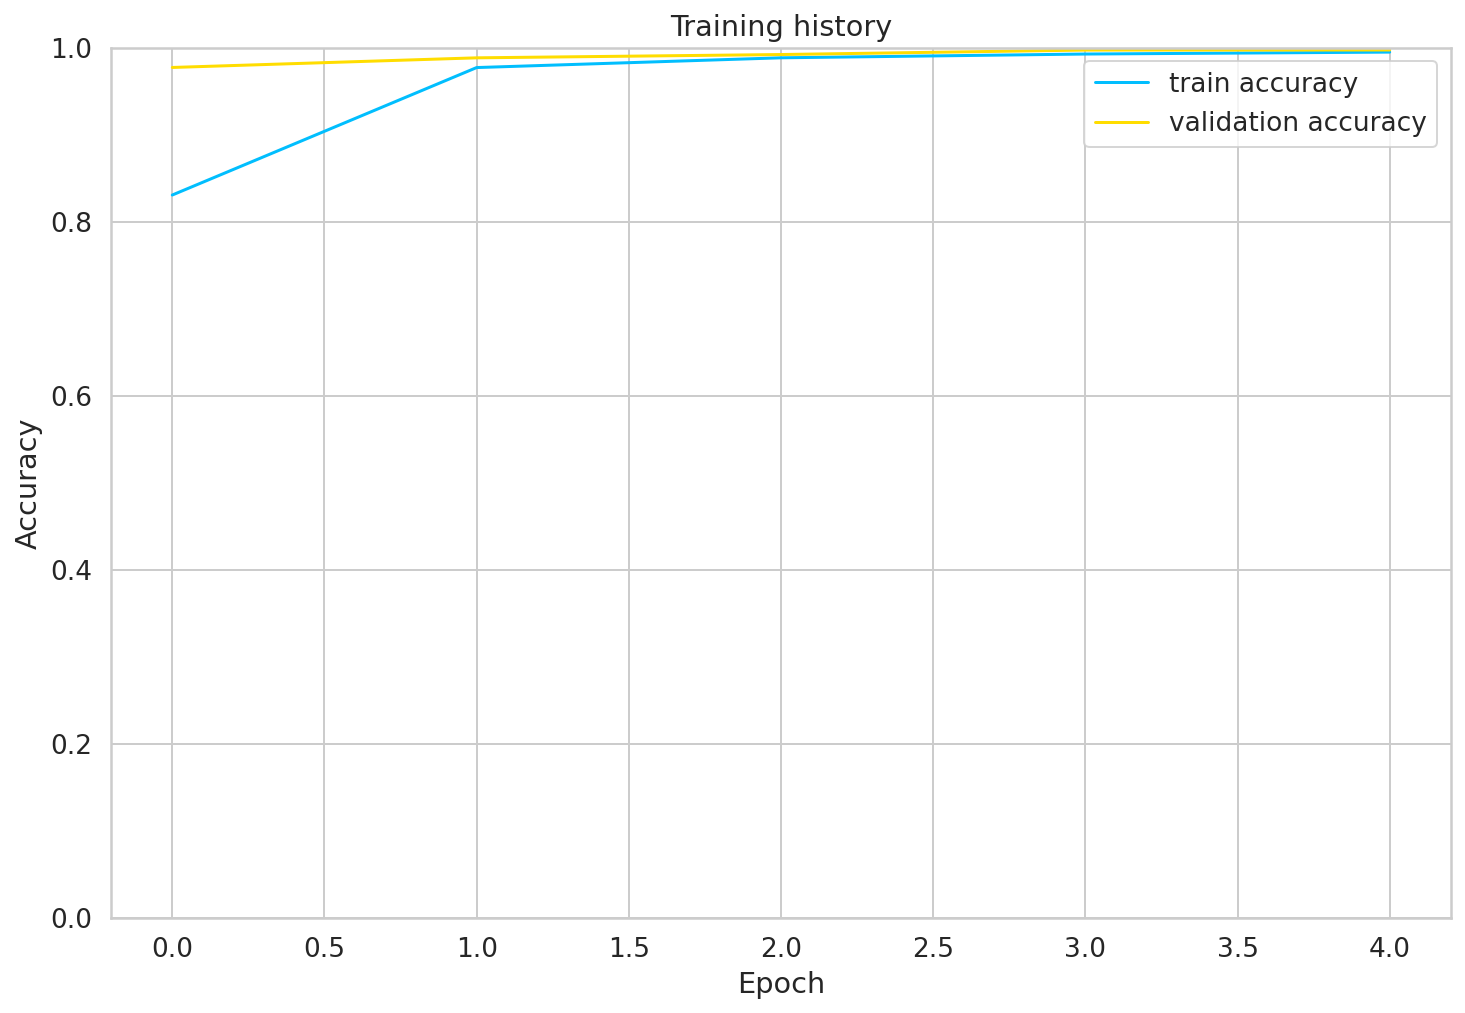

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.9945646600348682

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  Tweet_text = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["Tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      Tweet_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return Tweet_text, predictions, prediction_probs, real_values

In [ ]:
y_Tweet_text, y_pred, y_pred_prob, y_test= get_predictions(model,test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

             Services       1.00      1.00      1.00      4273
        Rental amount       0.94      1.00      0.97       142
                Speed       1.00      0.99      0.99      1020
International Roaming       0.99      0.98      0.99       772
              Network       0.99      1.00      0.99      1129
              Replies       0.99      0.99      0.99      1180
        Customer Care       1.00      0.98      0.99       758
        https twitter       1.00      0.99      0.99       477

             accuracy                           0.99      9751
            macro avg       0.99      0.99      0.99      9751
         weighted avg       0.99      0.99      0.99      9751



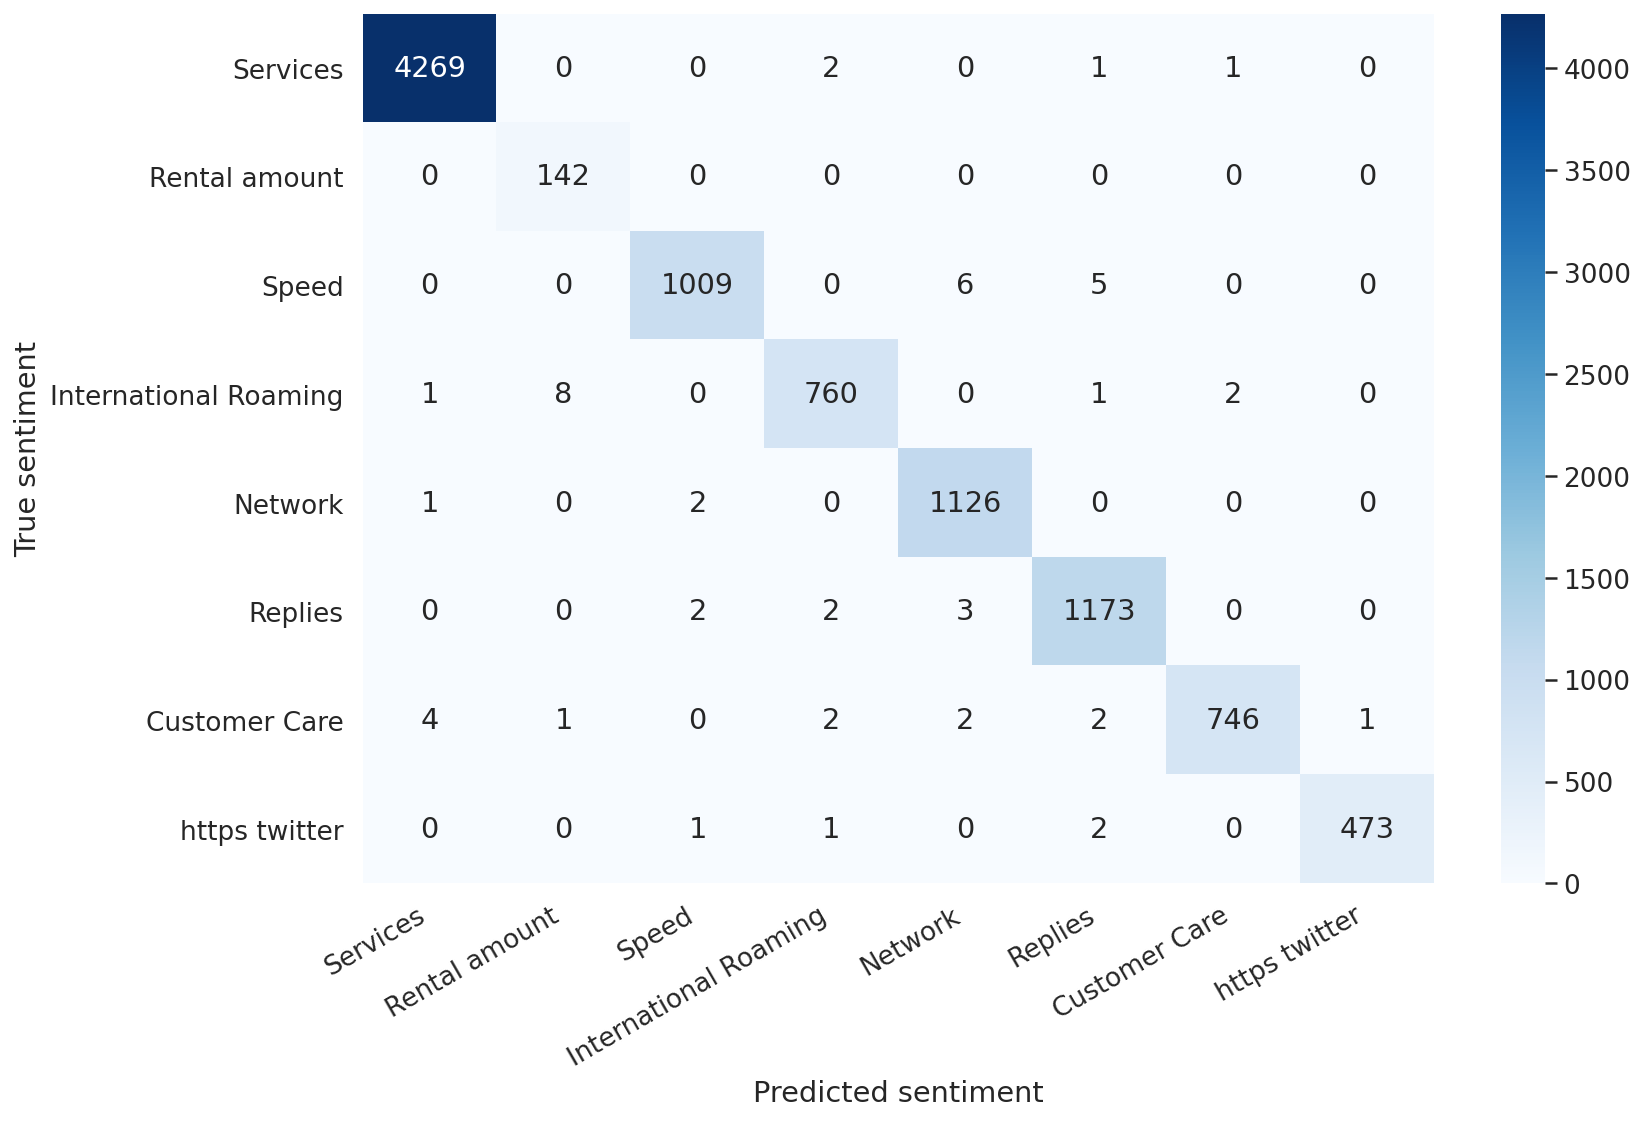

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Above confirms our Topic Categorization has a good accuracy.

Let's have a look at an example from our test data:

In [ ]:
idx = 20
review_text = y_Tweet_text[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_prob[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'Topic : {class_names[true_sentiment]}')

this happened first place this some kind scam activate service
customers most customers stop even question this happened please stop
this refund balan

Topic : Services


Let's see how our model works on any random text

In [ ]:
random_text="call droppping happening frequently"

In [ ]:
encoded_review = tokenizer.encode_plus(
  random_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Random Text : {random_text}')
print(f'Topic  : {class_names[prediction]}')

Random Text : call droppping happening frequently
Topic  : Services
